In [3]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Load image and preprocess
def load_img(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

In [5]:
# Show image
def show_img(tensor, title):
    img = tensor.squeeze().detach().cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [8]:
# Load content and style images
content = load_img('content.jpg')
style = load_img('style.jpg')

In [9]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = content.to(device)
style = style.to(device)

In [10]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = content.to(device)
style = style.to(device)

In [11]:
# Load pre-trained VGG19 model (suppress deprecation warning)
from torchvision.models import vgg19, VGG19_Weights
vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 71.8MB/s]


In [12]:
# Function to extract features
def get_features(x, layers):
    feats = {}
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            feats[name] = x
    return feats

In [13]:
# Gram matrix function
def gram(x):
    b, c, h, w = x.size()
    x = x.view(c, h * w)
    return torch.mm(x, x.t())

In [14]:
# Specify layers for content and style
content_layer = ['21']
style_layers = ['0', '5', '10', '19', '28']

In [15]:
# Extract and detach features
c_feats = {k: v.detach() for k, v in get_features(content, content_layer).items()}
s_feats = get_features(style, style_layers)
s_grams = {l: gram(s_feats[l]).detach() for l in style_layers}

In [16]:
# Initialize target image
target = content.clone().requires_grad_(True)

In [17]:
# Optimizer
opt = torch.optim.Adam([target], lr=0.01)

Step 0, Loss: 25257823961088.0000


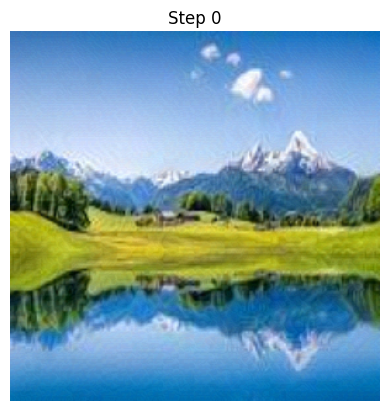

Step 50, Loss: 388054646784.0000


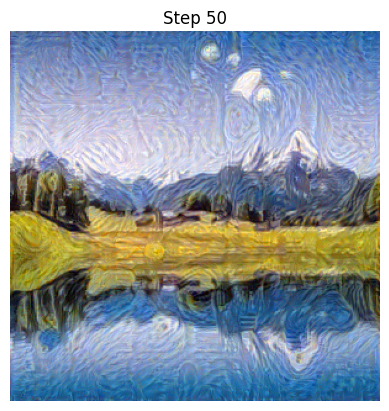

Step 100, Loss: 195950034944.0000


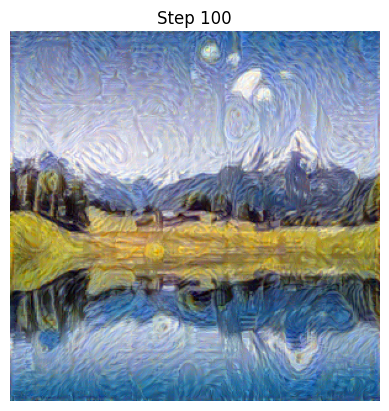

Step 150, Loss: 135805034496.0000


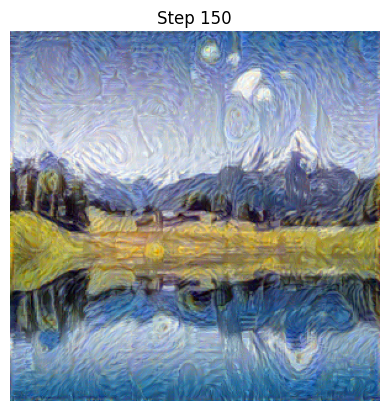

Step 200, Loss: 104610873344.0000


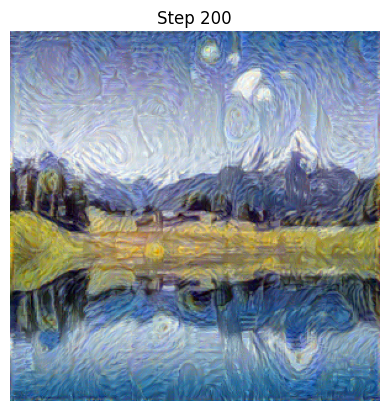

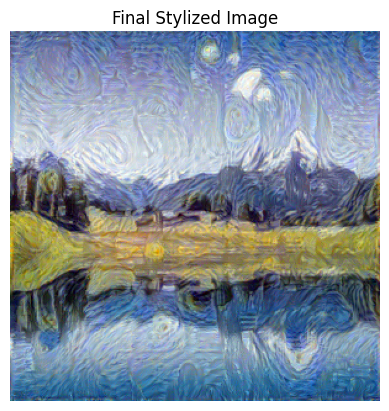

In [18]:
# Style transfer loop
for step in range(201):
    t_feats = get_features(target, content_layer + style_layers)

    # Content loss
    c_loss = torch.mean((t_feats['21'] - c_feats['21']) ** 2)

    # Style loss
    s_loss = 0
    for l in style_layers:
        target_gram = gram(t_feats[l])
        style_gram = s_grams[l]
        s_loss += torch.mean((target_gram - style_gram) ** 2)

    # Total loss
    loss = c_loss + 1e6 * s_loss

    # Backpropagation
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Clamp to keep image values in range
    with torch.no_grad():
        target.clamp_(0, 1)

    # Display progress
    if step % 50 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")
        show_img(target, f"Step {step}")

# Final result
show_img(target, "Final Stylized Image")